In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, MaxPooling2D, Flatten, Dense, Conv2D, Input, BatchNormalization, MaxPool2D, Lambda, Concatenate, Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import initializers
import tensorflow.keras.backend as K
import numpy as np
%load_ext tensorboard
import datetime
!rm -rf ./logs/ 

### Make The Dataset

In [2]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255
x_test = x_test / 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

image_size = (32,32,3)

# flip images
x_train_flipped = np.flip(x_train, axis=3)
x_train = np.append(x_train, x_train_flipped, axis=0)
y_train = np.append(y_train, np.copy(y_train), axis=0)
x_train_flipped = None
print('flipped')

# mix it up
x_train, y_train = unison_shuffled_copies(x_train, y_train)
print('permuted')
print(x_train.shape, y_train.shape)

170500096/170498071 [==============================] - 2s 0us/step
flipped
permuted
(100000, 32, 32, 3) (100000, 10)


In [4]:
def make_set(nums):
  ytrain = np.zeros((y_train.shape[0], len(nums)))
  ytest = np.zeros((y_test.shape[0], len(nums)))

  for i in range(y_train.shape[0]):
    made1 = False
    arg = np.argmax(y_train[i])
    for x in range(len(nums)):
      if arg in nums[x]:
        ytrain[i][x] = 1.0
        made1 = True
    if not made1: 
      ytrain[i] += 1.0/len(nums)

  for i in range(y_test.shape[0]):
    made1 = False
    arg = np.argmax(y_train[i])
    for x in range(len(nums)):
      if arg in nums[x]:
        ytest[i][x] = 1.0
        made1 = True
    if not made1: 
      ytest[i] += 1.0/len(nums)
  
  return ytrain, ytest

In [5]:
def make_level(nums):
  ytrain = np.zeros((y_train.shape[0], len(nums)))
  ytest = np.zeros((y_test.shape[0], len(nums)))

  for i in range(y_train.shape[0]):
    arg = np.argmax(y_train[i])
    for x in range(len(nums)):
      if arg in nums[x]:
        ytrain[i][x] = 1.0
        made1 = True

  for i in range(y_test.shape[0]):
    arg = np.argmax(y_test[i])
    for x in range(len(nums)):
      if arg in nums[x]:
        ytest[i][x] = 1.0
        made1 = True
  
  return ytrain, ytest

In [6]:
l1 = 1e-4
l2 = 5e-4

# seq = Sequential([
#   Input(shape=(32,32,3)),
#   Conv2D(64, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)),
#   Conv2D(64, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)),
#   BatchNormalization(),
#   Dropout(0.5),
#   Conv2D(128, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)),
#   Conv2D(128, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)),
#   BatchNormalization(),
#   Dropout(0.5),
#   Conv2D(256, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)),
#   Conv2D(256, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)),
#   BatchNormalization(),
#   Dropout(0.5),
#   Conv2D(512, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)),
#   Conv2D(512, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)),
#   BatchNormalization(),
#   Dropout(0.5),
#   MaxPool2D(),
#   MaxPool2D(),
#   Flatten(),
#   Dense(10, activation="softmax")
# ])

# seq.summary()

class mpu(Model):
  def __init__(self, root=False, end=False, threshold=0.3, name=None):
    super(mpu, self).__init__(name=name)

    self.pred1 = Conv2D(64, (3,3), padding="same", activation="relu")
    self.pred2 = Conv2D(64, (3,3), padding="same", activation="relu")
    self.pred3 = MaxPool2D()
    self.pred4 = Flatten()
    self.pred5 = Dense(1, activation="sigmoid")

    self.base1 = Conv2D(64, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))
    self.base2 = Conv2D(64, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))
    self.base3 = BatchNormalization()
    self.base4 = Dropout(0.5)

    self.connect = 0
    self.root = root
    self.threshold = threshold
    self.end = end
  
  def call(self, inputs):

    if self.root:
      b = self.base1(inputs)
      b = self.base2(b)
      b = self.base3(b)
      b = self.base4(b)
      return b

    p = self.pred1(inputs)
    p = self.pred2(p)
    p = self.pred3(p)
    p = self.pred4(p)
    p = self.pred5(p)

    if self.end or (self.connect == 1 and p[0] < threshold):
      return p
    
    b = self.base1(inputs)
    b = self.base2(b)
    b = self.base3(b)
    b = self.base4(b)

    return [p, b]

In [7]:
class Node:
  def __init__(self, val=None, branches=False, isRoot=False, end=False, name="mpu"):
    self.isRoot = isRoot
    self.branches = branches or []
    self.end = end
    self.model = mpu(root=isRoot, end=end, name=name)
    self.val = val
    self.name = name
  def addLeafs(self, nums=None):
    for i in nums: self.branches.append(Node(val=i, end=True))
  def build(self, inp):
    if self.end:
      return [self.model(inp), []]
    output = self.model(inp)
    connect = output if self.end or self.isRoot else output[1]
    models = [b.build(connect) for b in self.branches]
    print(self.name, models)
    
    connections = []
    for m in models:
      connections.extend(m[1])
    return output, connections

road [[<tf.Tensor 'mpu/dense_8/Sigmoid:0' shape=(None, 1) dtype=float32>, []], [<tf.Tensor 'mpu/dense_9/Sigmoid:0' shape=(None, 1) dtype=float32>, []]]
nalive [[<tf.Tensor 'mpu/dense_3/Sigmoid:0' shape=(None, 1) dtype=float32>, []], [<tf.Tensor 'mpu/dense_4/Sigmoid:0' shape=(None, 1) dtype=float32>, []], ([<tf.Tensor 'road/dense_7/Sigmoid:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'road/dropout_7/cond/Identity:0' shape=(None, 32, 32, 64) dtype=float32>], [])]
pet [[<tf.Tensor 'mpu/dense_11/Sigmoid:0' shape=(None, 1) dtype=float32>, []], [<tf.Tensor 'mpu/dense_12/Sigmoid:0' shape=(None, 1) dtype=float32>, []]]
medium [[<tf.Tensor 'mpu/dense_14/Sigmoid:0' shape=(None, 1) dtype=float32>, []], [<tf.Tensor 'mpu/dense_15/Sigmoid:0' shape=(None, 1) dtype=float32>, []]]
alive [[<tf.Tensor 'mpu/dense_5/Sigmoid:0' shape=(None, 1) dtype=float32>, []], [<tf.Tensor 'mpu/dense_6/Sigmoid:0' shape=(None, 1) dtype=float32>, []], ([<tf.Tensor 'pet/dense_10/Sigmoid:0' shape=(None, 1) dtype=float32>, <

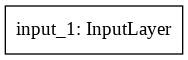

In [8]:
root = Node(isRoot=True, name='root')
nalive = Node(name='nalive')
alive = Node(name='alive')
nalive.addLeafs([0, 8])
alive.addLeafs([2, 6])

road = Node(name='road')
road.addLeafs([1, 9])
nalive.branches.append(road)

pet = Node(name='pet')
pet.addLeafs([3, 5])
medium = Node(name='medium')
medium.addLeafs([4, 7])
alive.branches.append(pet)
alive.branches.append(medium)
root.branches.extend([nalive, alive])

inp = Input(shape=(32,32,3))
out, conn = root.build(inp)
print(conn)
m = Model(inputs=inp, outputs=conn, name="full")
plot_model(m)

In [9]:
root = mpu(root=True, name='root')
nalive = mpu(name='nalive')
alive = mpu(name='alive')
plane = mpu(end=True, name='plane')
ship = mpu(end=True, name='ship')
road = mpu(name='road')
auto = mpu(end=True, name='auto')
truck = mpu(end=True, name='truck')

bird = mpu(end=True, name='bird')
frog = mpu(end=True, name='frog')
pet = mpu(name='pet')
cat = mpu(end=True, name='cat')
dog = mpu(end=True, name='dog')
medium = mpu(name='medium')
horse = mpu(end=True, name='horse')
deer = mpu(end=True, name='deer')

all the models

In [10]:
imp = Input(shape=(32,32,3))
rootM = root(imp)
naliveM = nalive(rootM)
planeM = plane(naliveM[1]) # output 0
shipM = ship(naliveM[1]) # output 8
roadM = road(naliveM[1])
autoM = auto(roadM[1]) # output 1
truckM = truck(roadM[1]) # output 9
# 
aliveM = alive(rootM)
birdM = bird(aliveM[1]) # output 2
frogM = frog(aliveM[1]) # output 6


petM = pet(aliveM[1])
catM = cat(petM[1]) # output 3
dogM = dog(petM[1]) # output 5
mediumM = medium(aliveM[1])
horseM = horse(mediumM[1]) # output 4
deerM = deer(mediumM[1]) # output 7

fine = Concatenate(name="fine")([planeM, autoM, birdM, catM, horseM, dogM, frogM, deerM, shipM, truckM])
coarse2 = Concatenate(name="coarse2")([roadM[0], petM[0], mediumM[0]])
coarse1 = Concatenate(name="coarse1")([naliveM[0], aliveM[0]])

full = Model(imp, [coarse1, coarse2, fine], name="full")

plot_model(full, show_shapes=True)

individuals = []

inds = [naliveM[0], aliveM[0], roadM[0], petM[0], mediumM[0], planeM, autoM, birdM, catM, horseM, dogM, frogM, deerM, shipM, truckM]
for i in inds:
  individuals.append(Model(imp, i))

In [11]:
full.summary()

Model: "full"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
root (mpu)                      (None, 32, 32, 64)   38976       input_2[0][0]                    
__________________________________________________________________________________________________
nalive (mpu)                    [(None, 1), (None, 3 164353      root[0][0]                       
__________________________________________________________________________________________________
alive (mpu)                     [(None, 1), (None, 3 164353      root[0][0]                       
_______________________________________________________________________________________________

dataset ys for the models

In [12]:
coarse1_train, coarse1_test = make_level([[0, 1, 8, 9], [2, 3, 4, 5, 6, 7]])
coarse2_train, coarse2_test = make_level([[1, 9], [3, 5], [4, 7]])

In [ ]:
for i in range(20):
  print(y_test[i], coarse_test[i])

In [14]:
adam = optimizers.Adam(learning_rate=0.0001)
sgd = optimizers.SGD(learning_rate=0.0005, momentum=0.9, nesterov=True)
full_callback = tf.keras.callbacks.TensorBoard(log_dir="./full")
import functools
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)
full.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# rooti.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# nalivei.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# alivei.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# roadi.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# peti.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# mediumi.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
!rm -rf ./full/ 

In [18]:
with tf.device('/GPU:0'):
  full.fit(x_train, [coarse1_train, coarse2_train, y_train], epochs=30, batch_size=64,validation_data=(x_test, [coarse1_test, coarse2_test, y_test]))

Epoch 1/30
1563/1563 [==============================] - 147s 94ms/step - loss: 4.7629 - coarse1_loss: 0.4101 - coarse2_loss: 0.5774 - fine_loss: 1.9773 - coarse1_accuracy: 0.8008 - coarse2_accuracy: 0.3507 - fine_accuracy: 0.2469 - val_loss: 4.4899 - val_coarse1_loss: 0.3254 - val_coarse2_loss: 0.5274 - val_fine_loss: 1.8673 - val_coarse1_accuracy: 0.8620 - val_coarse2_accuracy: 0.3151 - val_fine_accuracy: 0.3298
Epoch 2/30
1563/1563 [==============================] - 145s 93ms/step - loss: 3.9392 - coarse1_loss: 0.2958 - coarse2_loss: 0.3746 - fine_loss: 1.5265 - coarse1_accuracy: 0.8757 - coarse2_accuracy: 0.5400 - fine_accuracy: 0.4568 - val_loss: 4.0259 - val_coarse1_loss: 0.3464 - val_coarse2_loss: 0.3634 - val_fine_loss: 1.6011 - val_coarse1_accuracy: 0.8473 - val_coarse2_accuracy: 0.5388 - val_fine_accuracy: 0.4411
Epoch 3/30
1563/1563 [==============================] - 145s 93ms/step - loss: 3.5216 - coarse1_loss: 0.2580 - coarse2_loss: 0.2850 - fine_loss: 1.2907 - coarse1_accu

In [ ]:
with tf.device('/GPU:0'):
  seq.fit(x_train, y_train, epochs=30, batch_size=64,validation_data=(x_test, y_test))

In [ ]:
seq.predict(x_test[:10])

In [ ]:
full.load_weights('ceb.hdf5')

In [ ]:
full.predict(x_test[:5])

In [ ]:
# full.load_weights('ceb.hdf5')
import functools
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'
# seq.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',top3_acc])
# ])
# model.compile(Adam(lr=.001),#
#     optimizers.RMSprop(lr=2e-5),
#         loss='categorical_crossentropy',
#         metrics=['accuracy','top_k_categorical_accuracy',top3_acc])

#     model.evaluate(X_test, y_test)
full.evaluate(x_test, [coarse1_test, coarse2_test, y_test])

TypeError: ignored

In [ ]:
%tensorboard --logdir full

### Test The Networks

In [ ]:
# all = Model(imp, [coarse, interM, fine])
tests = full.predict(x_test)

In [ ]:
# count = 0
# for t in tests:
#   print(count)
#   count += 1
#   print(t[:30])

In [ ]:
abovep1 = 0
for i in tests[2]:
  if np.argmax(i) > 0:
    abovep1 += 1
print(abovep1, "/", len(tests[0]), '(', str(100*abovep1/len(tests[0])) + '%', ')')

9140 / 10000 ( 91.4% )


In [ ]:
import copy
hierarchy = {
    0: [[0, 0],         [2, 0]],
    8: [[0, 0],         [2, 8]],
    1: [[0, 0], [1, 0], [2, 1]],
    9: [[0, 0], [1, 0], [2, 9]],
    2: [[0, 1],         [2, 2]],
    6: [[0, 1],         [2, 6]],
    3: [[0, 1], [1, 1], [2, 3]],
    5: [[0, 1], [1, 1], [2, 5]],
    4: [[0, 1], [1, 2], [2, 4]],
    7: [[0, 1], [1, 2], [2, 7]]
}


lt = len(tests[0])
# threshold = 1e-4

for threshold in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
  total = 0
  allZero = 0
  for i in range(lt):
    arg = np.argmax(y_test[i])
    pos = hierarchy[arg]
    passed = True



    finals = copy.deepcopy(tests[2][i])
    # print(arg, finals)

    # conditional

    if tests[0][i][0] < threshold:
      finals[0], finals[1], finals[8], finals[9] = 0, 0, 0, 0
    if tests[0][i][1] < threshold:
      finals[2], finals[3], finals[4], finals[5], finals[6], finals[7] = 0, 0, 0, 0, 0, 0
    if tests[1][i][0] < threshold: finals[1], finals[9] = 0, 0
    if tests[1][i][1] < threshold: finals[3], finals[5] = 0, 0
    if tests[1][i][2] < threshold: finals[4], finals[7] = 0, 0
    for e in range(10):
      if finals[e] < threshold: finals[e] = 0


    if np.argmax(finals) == arg and any(finals):
      total += 1
    if not any(finals):
      allZero += 1

    # full

    # print(arg, finals)
    # if np.argmax(finals) == arg: total += 1
    # indices = (-np.array(finals)).argsort()[:3]
    # if arg in indices: total += 1

    # single

    
    # for p in pos:
    #   if np.argmax(tests[p[0]][i]) != p[1]: 
    #     passed = False
    #     break
    # if passed: total += 1
    # break

  print(threshold, total/lt, allZero)
# print(allZero)




1e-06 0.732 1020
1e-05 0.6398 2299
0.0001 0.4893 4359
0.001 0.309 6573
0.01 0.1498 8416
0.1 0.0513 9469
